In [58]:
from enum import StrEnum
%load_ext autoreload
%autoreload 2

import datetime
from pydantic import BaseModel
from db.models import Match, Player, Surface
from db.db_utils import get_table
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
matches = get_table(Match)
matches = sorted(matches, key=lambda m: m.date)
players = get_table(Player)

In [59]:
class EloSurface(StrEnum):
    CLAY = "CLAY"
    GRASS = "GRASS"
    HARD_OR_INDOOR = "HARD_OR_INDOOR"
    ALL = "ALL"

class EloRanking(BaseModel):
    player_id: str
    elo_point: float
    date: datetime.date
    surface: EloSurface


In [60]:

def get_updated_elo(match: Match, player_id_to_elo_ranking: dict[str, float], K: float = 32):
    winner_id = match.player1_id
    loser_id = match.player2_id

    winner_elo = player_id_to_elo_ranking.get(winner_id, INITIAL_ELO)
    loser_elo = player_id_to_elo_ranking.get(loser_id, INITIAL_ELO)

    # Calculate expected scores using Elo formula
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    expected_loser = 1 - expected_winner

    # Actual results: 1 for winner, 0 for loser
    S_winner, S_loser = 1, 0

    # Update Elo ratings
    winner_elo_new = winner_elo + K * (S_winner - expected_winner)
    loser_elo_new = loser_elo + K * (S_loser - expected_loser)

    # Save updated ratings back to the dictionary
    player_id_to_elo_ranking[winner_id] = winner_elo_new
    player_id_to_elo_ranking[loser_id] = loser_elo_new

    # Optionally, return the new ratings
    return winner_elo_new, loser_elo_new

INITIAL_ELO = 1500
K = 32

def compute_elos(matches: list[Match], K: float, initial_elo: float, elo_surface: EloSurface) -> list[float]:
    elo_surface_to_surface = {
        EloSurface.CLAY: [Surface.CLAY],
        EloSurface.GRASS: [Surface.GRASS],
        EloSurface.HARD_OR_INDOOR: [Surface.HARD, Surface.INDOOR],
        EloSurface.ALL:[Surface.CLAY, Surface.GRASS, Surface.HARD, Surface.INDOOR]
    }

    filtered_matches = list(filter(lambda m: m.surface in elo_surface_to_surface[elo_surface], matches))

    player_id_to_elo_ranking = {
        player.player_id: INITIAL_ELO for player in players
    }

    all_elos = []
    for match in tqdm(matches, desc=f"Computing ELOs for surface {elo_surface} on {len(matches)} matches", unit="matches"):
        winner_new_elo, loser_new_elo = get_updated_elo(match, player_id_to_elo_ranking, K)
        update_date = (match.date + datetime.timedelta(days=1)).date()
        all_elos.extend(
            [
                EloRanking(
                    player_id=match.player1_id,
                    elo_point=winner_new_elo,
                    date=update_date,
                ),
                EloRanking(
                    player_id=match.player2_id,
                    elo_point=loser_new_elo,
                    date=update_date,
                )
            ]
        )

    return all_elos


all_elos = []
for elo_surface in EloSurface:
    elos_for_surface = compute_elos(matches, K, INITIAL_ELO, elo_surface=elo_surface)
    all_elos.extend(elos_for_surface)






AttributeError: 'Match' object has no attribute 'surface'

<Axes: title={'center': 'Elo Point : Alcaraz Carlos'}, xlabel='date'>

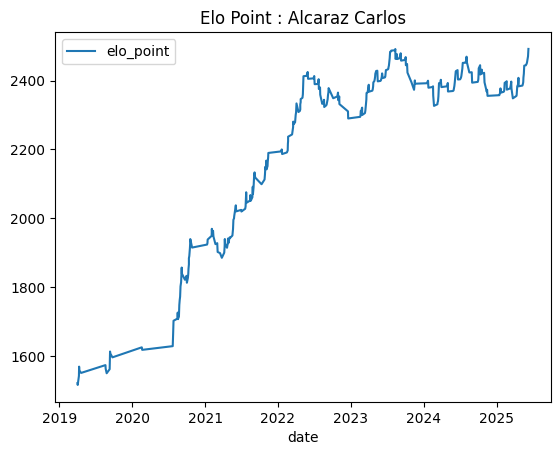

In [54]:
from db.db_utils import get_player_by_name

player = get_player_by_name("Alcaraz")

elo_rankings = list(
    sorted(
        filter(lambda elo: elo.player_id == player.player_id, all_elos),
        key=lambda elo: elo.date
    )
)

import pandas as pd

df = pd.DataFrame(list(map(lambda x: x.model_dump(), elo_rankings)))
df.plot.line(
    x="date",
    y="elo_point",
    title=f"Elo Point : {player.name}",
)